# Data Master: Case Cientista de Dados

![title](/home/vitor/Documents/dataMasters/clientes.jpg)

O objetivo desse case é encontrar clientes insatisfeitos. Para resolver este case teremos um conjunto de dados sintéticos contendo um grande número de variáveis <b>numéricas</b>. A coluna ‘TARGET’ é a variável resposta. Ela é igual a 1 para clientes insatisfeitos e igual a 0 para clientes satisfeitos. 

De acordo com o case sabemos que um falso positivo ocorre quando classificamos um cliente como insatisfeito, mas ela não se comporta como tal. Neste caso, o custo de preparar e executar uma ação de retenção é um valor fixo de 10 reais por cliente. Nada é ganho pois a ação de retenção não é capaz de mudar o comportamento do cliente. Um falso negativo ocorre quando um cliente é previsto como satisfeito, mas na verdade ele estava insatisfeito. Neste caso, nenhum dinheiro foi gasto e nada foi ganho. Um verdadeiro positivo é um cliente que estava insatisfeito e foi alvo de uma ação de retenção. O benefício neste caso é o lucro da ação (100 reais) menos os custos relacionados à ação deretenção (10 reais). Por fim, um verdadeiro negativo é um cliente insatisfeito e que não é alvo de nenhuma ação. O benefício neste caso é zero, isto é, nenhum custo, mas nenhum lucro

# Pipeline da Solução Proposta

# Imports

In [1]:
# Essentials
import numpy as np
import pandas as pd

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Misc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.selection import DropCorrelatedFeatures

import warnings
warnings.filterwarnings("ignore")

## 1.0 - Carregamento dos Dados

In [2]:
dfTrain = pd.read_csv('santander-customer-satisfaction/train.csv')
print(" DATASET DE TREINO ")
print(f"    Quantidade de dados: {dfTrain.shape[0]}")
print(f"    Quantidade de colunas: {dfTrain.shape[1]}")

 DATASET DE TREINO 
    Quantidade de dados: 76020
    Quantidade de colunas: 371


### 1.1 - Remover coluna de identificação ID

In [3]:
# ### Remove unecessary column
dfTrain.drop(labels='ID', axis=1, inplace = True)

## 2.0 - Análise Exploratória dos Dados

Inicialmente vamos fazer uma análise exploratório para termos um entendimento inicial dos dados.

### 2.1 - Distribuição do Target

Proporção dos targets positivos no dataset: 3.96%
Número de clientes satisfeitos: 73012
Número de clientes insatisfeitos: 3008


Text(0.5, 1.0, 'Total de registros por classe')

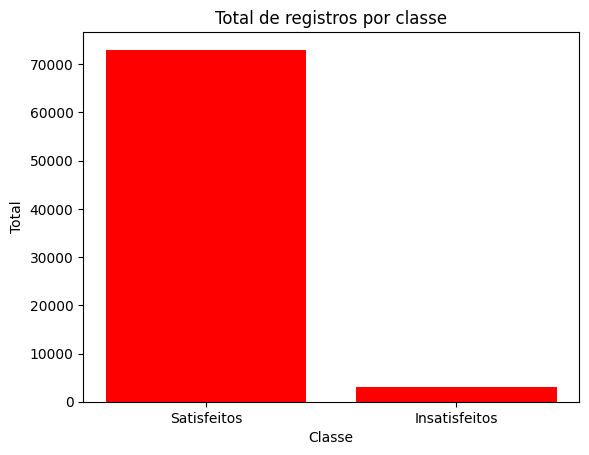

In [4]:
# ### Count by class
targetCounts  = dfTrain['TARGET'].value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(dfTrain['TARGET']))
print(f'Proporção dos targets positivos no dataset: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

### 2.2 - Análise dos Dados

In [5]:
# ### Preview the data we are working with
dfTrain.sample(5)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
47103,2,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35166.450000,0
53934,2,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
39526,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52753.830000,0
41199,2,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
63255,2,46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54150.150000,0


In [6]:
# ### Get descriptive statistics
dfTrain.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [7]:
# ### Get the number of distinct elements
dfTrain.nunique()

var3                         208
var15                        100
imp_ent_var16_ult1           596
imp_op_var39_comer_ult1     7551
imp_op_var39_comer_ult3     9099
                           ...  
saldo_medio_var44_hace3       33
saldo_medio_var44_ult1       141
saldo_medio_var44_ult3       141
var38                      57736
TARGET                         2
Length: 370, dtype: int64

### 2.3 - Checar os tipos de Dados

In [8]:
dfTrain.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Data columns (total 370 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    var3                           int64  
 1    var15                          int64  
 2    imp_ent_var16_ult1             float64
 3    imp_op_var39_comer_ult1        float64
 4    imp_op_var39_comer_ult3        float64
 5    imp_op_var40_comer_ult1        float64
 6    imp_op_var40_comer_ult3        float64
 7    imp_op_var40_efect_ult1        float64
 8    imp_op_var40_efect_ult3        float64
 9    imp_op_var40_ult1              float64
 10   imp_op_var41_comer_ult1        float64
 11   imp_op_var41_comer_ult3        float64
 12   imp_op_var41_efect_ult1        float64
 13   imp_op_var41_efect_ult3        float64
 14   imp_op_var41_ult1              float64
 15   imp_op_var39_efect_ult1        float64
 16   imp_op_var39_efect_ult3        float64
 17   imp_op_var39_ult1            

In [9]:
dataType = dfTrain.dtypes.value_counts()
dataType

int64      259
float64    111
Name: count, dtype: int64

Text(0.5, 1.0, 'Total de colunas por tipo de dados')

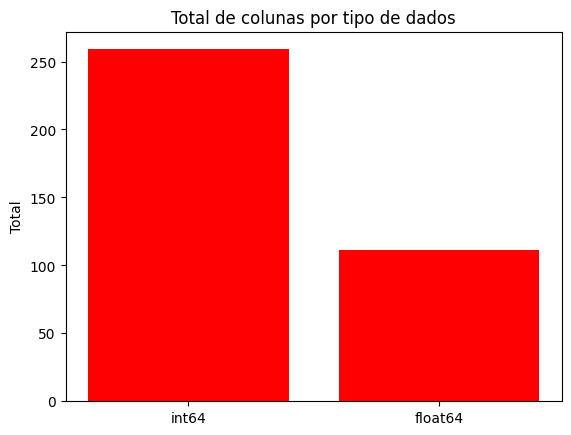

In [10]:
# ### Check columns for types
dataTypes = dfTrain.dtypes.value_counts()

# Recurso visual
plt.bar(dataTypes.index.astype(str), dataTypes.values, color='red')
plt.ylabel('Total')
plt.title('Total de colunas por tipo de dados')

### 2.4 - Check Null Values and Infinity Values

In [11]:
print(f"Número de valores nulos: {sum(dfTrain.isnull().sum())}")
print(f"Número de valores infinitos: {sum(dfTrain.isin([np.inf, -np.inf]).sum())}")

Número de valores nulos: 0
Número de valores infinitos: 0


## 3.0 - Limpeza dos Dados

### 3.1 - Removendo Linhas Duplicadas

In [12]:
# ### Drop duplicated rows
def dropDuplicatedRows(df, cols, keep=False):
    print(f'Dataset antes do processamento: {df.shape}')
    dfResult = df.drop_duplicates(subset=cols, inplace=False,keep=keep)
    print(f'Dataset após o processamento: {dfResult.shape}')
    return dfResult

# ### Remove duplicated Data and keep one element
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns, 'last')

Dataset antes do processamento: (76020, 370)
Dataset após o processamento: (71213, 370)


In [13]:
# Remove All Duplicated elements where the target is different
dfTrain = dropDuplicatedRows(dfTrain, dfTrain.columns.drop('TARGET'))

Dataset antes do processamento: (71213, 370)
Dataset após o processamento: (70947, 370)


Proporção dos targets positivos no dataset: 3.78%
Número de clientes satisfeitos: 68265
Número de clientes insatisfeitos: 2682


Text(0.5, 1.0, 'Total de registros por classe')

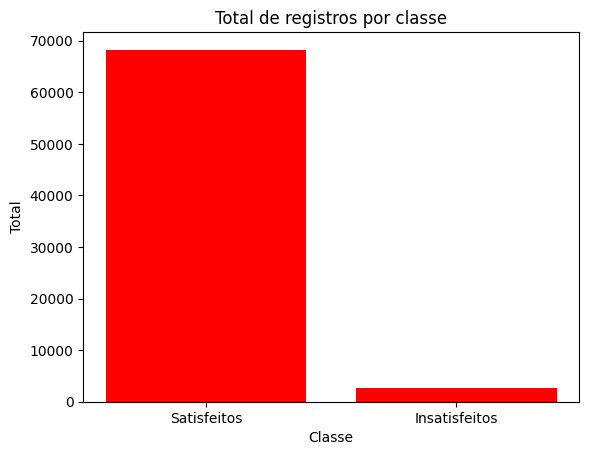

In [14]:
# ### Count by class
targetCounts  = dfTrain['TARGET'].value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(dfTrain['TARGET']))
print(f'Proporção dos targets positivos no dataset: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe')

## 4.0 - Dataset Split

Agora iremos realizar a divisão do Dataset em um conjunto de treinamento e um conjunto de validação.
O conjunto de treinamento irá possuir 80% dos dados e o conjunto de validação 20% dos dados. O split será realizado de forma estratificada em relação a target para preservar a distribuição do dataset original.

In [15]:
xTrain, xVal, yTrain, yVal = train_test_split(
                                dfTrain.drop(labels=['TARGET'], axis = 1),
                                dfTrain['TARGET'],
                                test_size = 0.20,
                                random_state = 423,
                                stratify = dfTrain['TARGET']
                            )

print(f'Dataset de treino: {xTrain.shape}')
print(f'Dataset de validação: {xVal.shape}')

Dataset de treino: (56757, 369)
Dataset de validação: (14190, 369)


Proporção dos targets positivos no dataset de treino: 3.78%
Número de clientes satisfeitos: 54611
Número de clientes insatisfeitos: 2146


Text(0.5, 1.0, 'Total de registros por classe no Dataset de Treino')

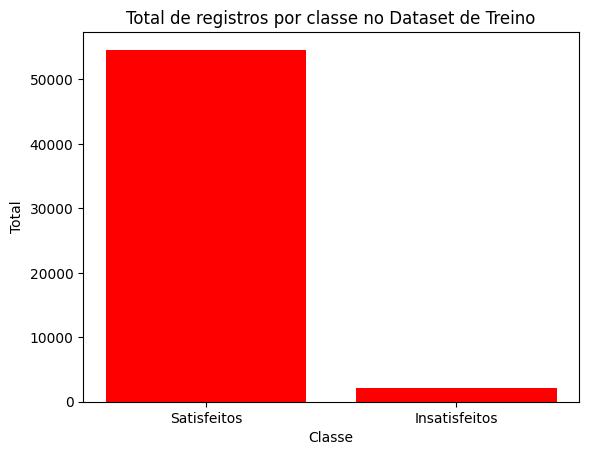

In [16]:
# ### Count by class
targetCounts  = yTrain.value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(yTrain))
print(f'Proporção dos targets positivos no dataset de treino: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe no Dataset de Treino')

Proporção dos targets positivos no dataset de validação: 3.78%
Número de clientes satisfeitos: 13654
Número de clientes insatisfeitos: 536


Text(0.5, 1.0, 'Total de registros por classe no Dataset de Validação')

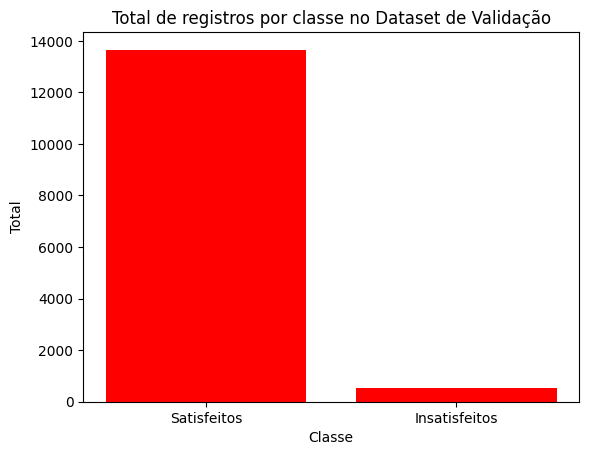

In [17]:
# ### Count by class
targetCounts  = yVal.value_counts()
dissatisfied = targetCounts[1]
satisfied   = targetCounts[0]

# ### Get proportion
prop = (dissatisfied/len(yVal))
print(f'Proporção dos targets positivos no dataset de validação: {prop:.2%}')
print(f"Número de clientes satisfeitos: {satisfied}")
print(f"Número de clientes insatisfeitos: {dissatisfied}")
      
# Show plot 
plt.bar(['Satisfeitos', 'Insatisfeitos'] ,targetCounts,color='red')
plt.xticks([0,1])
plt.xlabel('Classe')
plt.ylabel('Total')
plt.title('Total de registros por classe no Dataset de Validação')

## 5.0 - Limpar as variáveis no dataset de treino

In [18]:
xTrainAux = xTrain.copy()
setpsPipelineClear = []

### 5.1 - Remover variáveis com variância 0

In [19]:
class RemoveVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        
    def fit(self,df, y=None):
        cols = []
        
        variance0 = VarianceThreshold(threshold=self.threshold)
        variance0.fit(df)
        
        # ### Columns to remove
        self.removeColumns = [x for x in df.columns if x not in df.columns[variance0.get_support()]]
                
        return self
    
    def transform(self,df, y=None):
        df = df.drop(labels=self.removeColumns, axis=1, inplace = False)

        return df

In [20]:
variance0 = VarianceThreshold(threshold=0.0)
variance0.fit(xTrainAux)  # fit finds the features with variance 0

VarianceThreshold()

In [21]:
colsVariance0 = [x for x in xTrainAux.columns if x not in xTrainAux.columns[variance0.get_support()]]
#print(f'Número de colunas com um elemento: {len(colsVariance0)}')
#print(f'Columns:')
#colsVariance0

#### Plots

In [22]:
'''for col in colsVariance0:
    plt.figure(figsize=(3, 2))
    plt.xticks([0,1])
    sns.histplot(xTrainAux[col], color='red')'''

"for col in colsVariance0:\n    plt.figure(figsize=(3, 2))\n    plt.xticks([0,1])\n    sns.histplot(xTrainAux[col], color='red')"

In [23]:
# ### Add to Clear pipeline
setpsPipelineClear.append(('ZeroVariance', RemoveVarianceThreshold(threshold=0.0)))

In [24]:
#### Remove variables with variance 0
print(f'Número de colunas com um único dado {len(colsVariance0)} columns')
print(f'Antes da limpeza das colunas com 0 variância: {xTrainAux.shape}')
xTrainAux.drop(labels=colsVariance0, axis=1, inplace = True)
print(f'Depois da limpeza das colunas com 0 variância: {xTrainAux.shape}')


Número de colunas com um único dado 36 columns
Antes da limpeza das colunas com 0 variância: (56757, 369)
Depois da limpeza das colunas com 0 variância: (56757, 333)


### 5.2 - Verificar variáveis com baixa variância

In [25]:
variance0_01 = VarianceThreshold(threshold=0.01)
variance0_01.fit(xTrainAux)  # fit finds the features with variance 0

VarianceThreshold(threshold=0.01)

In [26]:
colsVariance0_01 = [x for x in xTrainAux.columns if x not in xTrainAux.columns[variance0_01.get_support()]]
#print(f'Número de colunas com baixa variância: {len(colsVariance0_01)}')
#print(f'Colunas com baixa variância:')
#colsVariance0_01

In [27]:
'''for col in colsVariance0_01:
    plt.figure(figsize=(5, 3))
    sns.histplot(xTrainAux[col], color='red')'''


"for col in colsVariance0_01:\n    plt.figure(figsize=(5, 3))\n    sns.histplot(xTrainAux[col], color='red')"

In [28]:
'''for col in colsVariance0_01:
    print(xTrainAux[col].value_counts())'''

'for col in colsVariance0_01:\n    print(xTrainAux[col].value_counts())'

In [29]:
print(f'Antes da limpeza das colunas com baixa variância: {xTrainAux.shape}')
xTrainAux.drop(labels=colsVariance0_01, axis=1, inplace = True)
print(f'Depois da limpeza das colunas com baixa variância: {xTrainAux.shape}')
print(f'Número de colunas removidas {len(colsVariance0_01)} columns')

Antes da limpeza das colunas com baixa variância: (56757, 333)
Depois da limpeza das colunas com baixa variância: (56757, 274)
Número de colunas removidas 59 columns


In [30]:
# ### Add to Clear pipeline
setpsPipelineClear.append(('LowVariance', RemoveVarianceThreshold(threshold=0.01)))

###  5.3 - Remoção de Variáveis Concentradas

In [31]:
def findConcentredVariables(df, perct):
    
    cols = []
    perct = perct/100.00
    
    for column in df.columns:
        sum = 0

        for i in range(1, len(df[column].value_counts()), 1):
            sum += df[column].value_counts().iloc[i]

        if sum < np.floor(len(df)*perct):
            cols.append(column)

    return cols

In [32]:

class RemoveConcentredVariables(BaseEstimator, TransformerMixin):
    def __init__(self, perct):
        self.perct = perct/100.00
        
    def fit(self,df, y=None):
        cols = []
        
        for column in df.columns:
            sum = 0
    
            for i in range(1, len(df[column].value_counts()), 1):
                sum += df[column].value_counts().iloc[i]
    
            if sum < np.floor(len(df)*self.perct):
                cols.append(column)
        
        # ### Columns to remove
        self.removeColumns = cols
                
        return self
    
    def transform(self,df, y=None):
        df = df.drop(labels=self.removeColumns, axis=1, inplace = False)
        
        return df

In [33]:
dropConcentredVariables = findConcentredVariables(xTrainAux, 0.50)
print(f'Número de variáveis concentradas: {len(dropConcentredVariables)}')

Número de variáveis concentradas: 112


In [34]:
print(f'Números de colunas removidas {len(dropConcentredVariables)} columns')
print(f'Antes da limpeza das variáveis concentradas: {xTrainAux.shape}')
xTrainAux.drop(labels=dropConcentredVariables, axis=1, inplace = True)
print(f'Depois da limpeza das variáveis concentradas: {xTrainAux.shape}')

Números de colunas removidas 112 columns
Antes da limpeza das variáveis concentradas: (56757, 274)
Depois da limpeza das variáveis concentradas: (56757, 162)


In [35]:
# ### Add to Clear pipeline
setpsPipelineClear.append(('ConcentredVariables', RemoveConcentredVariables(0.50)))

### 5.4 - Remoção de Variáveis Duplicadas

In [36]:
duplicates = DropDuplicateFeatures()
# find duplicated features in the train set
duplicates.fit(xTrainAux)

DropDuplicateFeatures()

In [37]:
class RemoveDuplicateFeatures(BaseEstimator, TransformerMixin):
      
    def fit(self,df, y=None):
        cols = []
        
        duplicates = DropDuplicateFeatures()
        duplicates.fit(df)
        
        # ### Columns to remove
        self.removeColumns = [x for x in df.columns if x not in df.columns[duplicates.get_support()]]
                
        return self
    
    def transform(self,df, y=None):
        df = df.drop(labels=self.removeColumns, axis=1, inplace = False)

        return df

In [38]:
# the groups or identical variables can be seen in the 
# attribute duplicated_feature_sets

dropFeaturesDuplicated = duplicates.features_to_drop_
dropFeaturesDuplicated


#print(f'Variáveis duplicadas:')
#print(dropFeaturesDuplicated)
#print('\nGrupo das colunas duplicadas:')
#duplicates.duplicated_feature_sets_

{'ind_var25', 'ind_var26', 'ind_var37', 'num_var25', 'num_var26', 'num_var37'}

In [39]:
# we can go ahead and check that these variables are indeed identical

xTrainAux['ind_var26'].equals(xTrainAux['ind_var26_0'])

True

In [40]:
# inspect the values of some observations

xTrainAux[['ind_var26','ind_var26_0']].head()

,ind_var26,ind_var26_0
44832,0,0
539,0,0
571,0,0
67644,0,0
41779,0,0


In [41]:
print(f'Número de variáveis duplicadas removidas {len(dropFeaturesDuplicated)} columns')
print(f'Antes de remover as variáveis duplicadas : {xTrainAux.shape}')
xTrainAux.drop(labels=dropFeaturesDuplicated, axis=1, inplace = True)
print(f'Depois de remover as variáveis duplicadas : {xTrainAux.shape}')

Número de variáveis duplicadas removidas 6 columns
Antes de remover as variáveis duplicadas : (56757, 162)
Depois de remover as variáveis duplicadas : (56757, 156)


In [42]:
# ### Add to Clear pipeline
setpsPipelineClear.append(('DuplicateFeatures', RemoveDuplicateFeatures()))

### 5.5 - Remoção de Variáveis Altamente Correlacionadas

In [43]:
dcf = DropCorrelatedFeatures(threshold=0.80)
dcf.fit(xTrainAux)

DropCorrelatedFeatures()

In [44]:
class RemoveCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        
    def fit(self,df, y=None):
        cols = []
        
        duplicates = DropCorrelatedFeatures(threshold=self.threshold)
        duplicates.fit(df)
        
        # ### Columns to remove
        self.removeColumns = [x for x in df.columns if x not in df.columns[duplicates.get_support()]]
                
        return self
    
    def transform(self,df, y=None):
        df = df.drop(labels=self.removeColumns, axis=1, inplace = False)

        return df

In [45]:
corrFeaturesDrop = dcf.features_to_drop_
#corrFeaturesDrop

In [46]:
print(f'Número de variáveis removidas {len(corrFeaturesDrop)}')
print(f'Antes da remoção das variáveis correlacionadas : {xTrainAux.shape}')
xTrainAux.drop(labels=corrFeaturesDrop, axis=1, inplace = True)
print(f'Após a remoção das variáveis correlacionadas : {xTrainAux.shape}')

Número de variáveis removidas 88
Antes da remoção das variáveis correlacionadas : (56757, 156)
Após a remoção das variáveis correlacionadas : (56757, 68)


In [47]:
# ### Add to Clear pipeline
setpsPipelineClear.append(('CorrelatedFeatures', RemoveCorrelatedFeatures(threshold=0.80)))

## 5.6 - Construção do Pipeline para Limpar os Dados

In [48]:
setpsPipelineClear

[('ZeroVariance', RemoveVarianceThreshold(threshold=0.0)),
 ('LowVariance', RemoveVarianceThreshold(threshold=0.01)),
 ('ConcentredVariables', RemoveConcentredVariables(perct=0.005)),
 ('DuplicateFeatures', RemoveDuplicateFeatures()),
 ('CorrelatedFeatures', RemoveCorrelatedFeatures(threshold=0.8))]

In [49]:
pipe_preprocessor = Pipeline(setpsPipelineClear)

In [50]:
pipe_preprocessor

Pipeline(steps=[('ZeroVariance', RemoveVarianceThreshold(threshold=0.0)),
                ('LowVariance', RemoveVarianceThreshold(threshold=0.01)),
                ('ConcentredVariables', RemoveConcentredVariables(perct=0.005)),
                ('DuplicateFeatures', RemoveDuplicateFeatures()),
                ('CorrelatedFeatures',
                 RemoveCorrelatedFeatures(threshold=0.8))])

In [51]:
clearDataPipeline = pipe_preprocessor.fit(xTrain,yTrain)

## 6.0 Análise de Outliers

In [52]:
# Check by Box Plot
cols = xTrainAux.columns
fig, axes = plt.subplots(18, 5, figsize=(40, 400))

for i, name in enumerate(cols):
    r, c = i // 5, i % 5
    sns.boxplot(data=xTrainAux[name], ax=axes[r, c])
    axes[r, c].set_title(name)

In [53]:
# Calculating IQR
Q1 = xTrainAux.quantile(0.25)
Q3 = xTrainAux.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

var3                                 0.0
var15                               17.0
imp_ent_var16_ult1                   0.0
imp_op_var39_comer_ult1              0.0
imp_op_var40_comer_ult3              0.0
                                  ...   
saldo_medio_var8_hace3               0.0
saldo_medio_var12_hace3              0.0
saldo_medio_var13_corto_hace3        0.0
saldo_medio_var13_largo_hace2        0.0
var38                            57236.4
Length: 68, dtype: float64


In [54]:
# Removing the outliers
train_data_ol = xTrainAux.copy()
train_data_out = train_data_ol[((train_data_ol >= (Q1 - 1.5 * IQR)) & (train_data_ol <= (Q3 + 1.5 * IQR))).all(axis = 1)]

print(f'Antes da remoção: {xTrainAux.shape}')
print(f'Depois da remoção: {train_data_out.shape}')

Antes da remoção: (56757, 68)
Depois da remoção: (13030, 68)


## 7.0 Limpar e Salvar os Dados

### Carregar os dados

In [55]:
dfTest = pd.read_csv('santander-customer-satisfaction/test.csv')
dfTest.drop(labels='ID', axis=1, inplace = True)

### Limpar os dados

In [56]:
xTrain = clearDataPipeline.transform(xTrain)
xVal = clearDataPipeline.transform(xVal)

In [57]:
dfTrainClear = pd.concat([xTrain, yTrain], axis=1)
dfValClear = pd.concat([xVal, yVal], axis=1)

In [58]:
dfTest = clearDataPipeline.transform(dfTest)

### Salvar os dados

In [59]:
dfTrainClear.to_csv('train_clear.csv', encoding='utf-8', index=False)
dfValClear.to_csv('val_clear.csv', encoding='utf-8', index=False)
dfTest.to_csv('teste_clear.csv', encoding='utf-8', index=False)

In [63]:
print(f"Formato do dataset de Treino: {xTrain.shape}")

Formato do dataset de Treino: (56757, 68)


In [64]:
print(f"Formato do dataset de Validação: {xVal.shape}")

Formato do dataset de Validação: (14190, 68)


In [65]:
print(f"Formato do dataset de Teste: {dfTest.shape}")

Formato do dataset de Teste: (75818, 68)
